# 1. Fresh Notebook Setup

The original notebook has been replaced with this clean version so we can rebuild the equal-eccentricity coupling plot from scratch using the updated `vrr_Omegas` module.

# 2. Configure Module Import Path

Add the project root to `sys.path` so the notebook can import `vrr_Omegas`, then confirm that the module loads.

In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

repo_root = Path.cwd().resolve()
if not (repo_root / "vrr_Omegas.py").exists():
    repo_root = repo_root.parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from vrr_Omegas import (
    Orbit,
    OrbitPair,
    J_exact,
    J_series,
    H_partial_sums,
    Omega_partial_sums,
    asymp_J_for_eta,
    omega_kernel_normalized,
    omega_asymptotic_from_meta,
    omega_hybrid_from_meta,
    regime_masks,
    contiguous_segments,
    I2_from_orbits,
    kernel_line_Omega_normalized,
 )

# 3. Implement `plot_left_panel_equal_e`

Define the plotting helper so it evaluates the coupling coefficients with `J_exact`, normalises them, and styles the curves as in the reference figure.

In [2]:
def plot_left_panel_equal_e(
    alpha_grid=np.linspace(0.02, 0.999, 600),
    e_list=(0.0, 0.3, 0.6, 0.9),
    L_display=(2, 4),
    s_method="simplified",
    N_overlap=100,
    G=1.0,
    mi=1.0,
    mj=1.0,
):
    """Plot |J|/(G m_i m_j / a_out) for equal-eccentricity orbits using J_exact."""

    alpha_grid = np.asarray(alpha_grid, dtype=float)
    ell_values = np.asarray(L_display, dtype=int)
    if ell_values.size == 0:
        raise ValueError("L_display must contain at least one multipole.")
    if np.any(ell_values % 2 != 0):
        raise ValueError("L_display must contain even multipoles.")

    method_lookup = {
        "simplified": "auto",
        "auto": "auto",
        "exact": "exact",
        "closed_form": "closed_form",
    }
    method = method_lookup.get(s_method, s_method)

    color_for_L = {2: "crimson", 4: "royalblue"}
    dash_long = (8, 4)
    dash_short = (4, 4)
    style_for_e = {
        0.0: ("-", None),
        0.3: ("--", dash_long),
        0.6: ("--", dash_short),
        0.9: (":", None),
    }

    fig, ax = plt.subplots(figsize=(12.4, 8.4))
    a_out = 1.0

    for e in e_list:
        if e not in style_for_e:
            raise ValueError(f"No linestyle configured for eccentricity {e}.")
        ls, dashes = style_for_e[e]
        curves = np.empty((ell_values.size, alpha_grid.size), dtype=float)

        for idx, alpha in enumerate(alpha_grid):
            a_in = alpha * a_out
            primary = Orbit(a=a_in, e=e, m=mi, G=G)
            secondary = Orbit(a=a_out, e=e, m=mj, G=G)
            pair = OrbitPair(primary, secondary, cos_inclination=1.0)
            J_vals = np.asarray(
                J_exact(
                    pair,
                    ell_values,
                    method=method,
                    nodes=N_overlap,
                ),
                dtype=float,
            )
            curves[:, idx] = J_vals / ((G * mi * mj) / a_out)

        for row, L in enumerate(ell_values):
            color = color_for_L.get(L, None)
            line, = ax.plot(alpha_grid, np.abs(curves[row]), color=color, lw=1.9, ls=ls)
            if dashes is not None:
                line.set_dashes(dashes)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylim([2e-4, 0.3])
    ax.set_xlim([1e-2, 1.0])
    ax.set_xlabel(r"$\alpha_{ij}=\min(a_i,a_j)/\max(a_i,a_j)$")
    ax.set_ylabel(r"$|\mathcal{J}_{ij\ell}|/(Gm_im_j/a_{\rm out})$")
    ax.set_title(r"$e_i=e_j\in\{0,0.3,0.6,0.9\}$;  $\ell=2$ (red), $\ell=4$ (blue)")
    ax.grid(True, which="both", alpha=0.3)

    color_handles = [Line2D([0], [0], color=color_for_L.get(L, "k"), lw=2) for L in ell_values]
    color_labels = [rf"$\ell={L}$" for L in ell_values]
    dash_handles = [
        Line2D([0], [0], color="k", lw=2.0, ls="-"),
        Line2D([0], [0], color="k", lw=2.0, ls="--", dashes=dash_long),
        Line2D([0], [0], color="k", lw=2.0, ls="--", dashes=dash_short),
        Line2D([0], [0], color="k", lw=2.0, ls=":"),
    ]
    dash_labels = [r"$e=0$", r"$e=0.3$", r"$e=0.6$", r"$e=0.9$"]

    legend_colors = ax.legend(color_handles, color_labels, title=r"multipole", loc="lower right", framealpha=0.9)
    ax.add_artist(legend_colors)
    ax.legend(dash_handles, dash_labels, title=r"eccentricity", loc="upper left", framealpha=0.9)

    plt.tight_layout()
    plt.show()

    return fig, ax

# 4. Reproduce Fig 1. (Upper left) from KT2015

Call the helper with the published parameter set to regenerate the left-panel comparison.

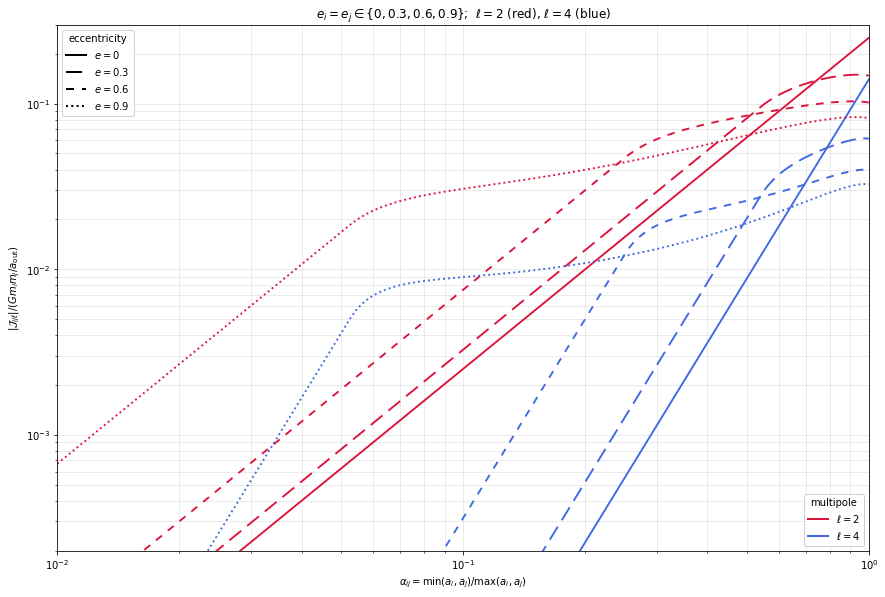

In [3]:
_, _ = plot_left_panel_equal_e(
    alpha_grid=np.linspace(0.01, 0.999, 600),
    e_list=(0.0, 0.3, 0.6, 0.9),
    L_display=(2, 4),
    s_method="exact",
    N_overlap=200,
)

# 5. Analytic $\Omega$ Kernel Helper

The module exposes `kernel_line_Omega_normalized`, so we can call it directly without redefining the expression here.

# 6. Plot $H$ and $\Omega$ with Asymptotics

Combine the exact series, asymptotic approximation, and optional hybrid corrections for the Hamiltonian and precession-frequency panels.

In [4]:
def plot_H_Omega_vs_eta_with_asymptotics(
    e_i=0.2,
    e_j=0.8,
    cos_theta=0.5,
    L_i=1.0,
    L_max_list=(4, 10, 20, 40),
    ells=None,
    eta_grid=np.geomspace(0.005, 20.0, 400),
    N_overlap=150,
    G=1.0,
    mi=1.0,
    mj=1.0,
    s_method="simplified",
    I2_func=None,
    xlim=(0.005, 20.0),
    ylim_H=(1e-6, 1.0),
    ylim_Om=(1e-6, 1.0),
    draw_kernel=False,
    kernel_use_cot_approx=False,
    kernel_color="k",
    kernel_lw=1.4,
    kernel_alpha=0.9,
    kernel_ls="-",
    show_kernel_line=None,
    use_cot_approx=None,
    show_hybrid_omega=False,
    hybrid_ell_max=4,
    hybrid_color="k",
    hybrid_lw=1.5,
    hybrid_alpha=0.9,
    hybrid_ls=":",
):
    """Two-panel comparison of exact, asymptotic, and hybrid couplings."""

    eta_grid = np.asarray(eta_grid, dtype=float)
    a_j = 1.0
    x = float(np.clip(cos_theta, -1.0, 1.0))
    effective_draw_kernel = bool(draw_kernel or (show_kernel_line is True))
    effective_kernel_use_cot = kernel_use_cot_approx if (use_cot_approx is None) else bool(use_cot_approx)

    if ells is not None:
        ell_sets = [np.asarray(ells, dtype=int)]
        ell_labels = [f"ℓ={ell_sets[0][0]}..{ell_sets[0][-1]}"]
        L_max_for_title = int(2 * ell_sets[0][-1])
    else:
        ell_sets = [np.arange(1, m + 1, dtype=int) for m in L_max_list]
        ell_labels = [rf"ℓ≤{m}" for m in L_max_list]
        L_max_for_title = int(2 * max(L_max_list))

    non_mask, over_mask, emb_mask = regime_masks(eta_grid, e_i, e_j)
    pair_records = []
    for idx, eta in enumerate(eta_grid):
        ai = eta * a_j
        use_overlap = bool(over_mask[idx] or emb_mask[idx])
        pair = OrbitPair(
            Orbit(a=ai, e=e_i, m=mi, G=G),
            Orbit(a=a_j, e=e_j, m=mj, G=G),
            cos_theta,
        )
        _, meta = asymp_J_for_eta(
            None,
            pair,
            use_overlap=use_overlap,
            I2_func=I2_func if use_overlap else None,
            return_meta=True,
        )
        pair_records.append(
            {
                "pair": pair,
                "meta": meta,
                "use_overlap": use_overlap,
                "L_i": pair.angular_momentum_primary,
            }
        )

    norm_H = (G * mi * mj) / a_j

    H_exact_list, H_asymp_list = [], []
    Om_exact_list, Om_asymp_list = [], []

    for ells_vec in ell_sets:
        H_ex_curve = np.empty_like(eta_grid, dtype=float)
        Om_ex_curve = np.empty_like(eta_grid, dtype=float)
        H_as_curve = np.full_like(eta_grid, np.nan, dtype=float)
        Om_as_curve = np.full_like(eta_grid, np.nan, dtype=float)

        for idx, eta in enumerate(eta_grid):
            record = pair_records[idx]
            pair = record["pair"]
            meta = record["meta"]
            use_overlap = record["use_overlap"]
            L_i_k = max(record["L_i"], 1e-12)

            J_ex = J_series(
                pair,
                ells_vec,
                use_sijl=True,
                s_method=s_method,
                N_overlap=N_overlap,
            )

            H_ex = H_partial_sums(ells_vec, J_ex, x)[-1]
            Om_ex = Omega_partial_sums(ells_vec, J_ex, x, L_i_k)[-1]
            H_ex_curve[idx] = np.abs(H_ex) / norm_H
            Om_ex_curve[idx] = np.abs(Om_ex) / ((G * mi * mj) / (a_j * L_i_k))

            J_as = asymp_J_for_eta(
                ells_vec,
                pair,
                use_overlap=use_overlap,
                I2_value=meta.I2,
            )

            if J_as is not None:
                H_as = H_partial_sums(ells_vec, J_as, x)[-1]
                omega_as_ps = omega_asymptotic_from_meta(ells_vec, x, L_i_k, meta)
                if omega_as_ps is not None:
                    Om_as_curve[idx] = np.abs(omega_as_ps[-1]) / ((G * mi * mj) / (a_j * L_i_k))
                H_as_curve[idx] = np.abs(H_as) / norm_H

        H_exact_list.append(H_ex_curve)
        H_asymp_list.append(H_as_curve)
        Om_exact_list.append(Om_ex_curve)
        Om_asymp_list.append(Om_as_curve)

    fig, axs = plt.subplots(2, 1, figsize=(8.0, 7.2), sharex=True)
    cmap = plt.get_cmap("viridis")
    colors = [cmap(i / (len(ell_sets) - 1 + 1e-12)) for i in range(len(ell_sets))]
    style_map = {"non": "-.", "ovr": ":", "emb": "-"}

    ax = axs[0]
    asymp_handles = []
    for i_set, (H_ex, H_as, label) in enumerate(zip(H_exact_list, H_asymp_list, ell_labels)):
        c = colors[i_set]
        for mask, ls in [(non_mask, style_map["non"]), (over_mask, style_map["ovr"]), (emb_mask, style_map["emb"])]:
            for start, end in contiguous_segments(mask):
                ax.plot(eta_grid[start:end + 1], H_ex[start:end + 1], color=c, lw=2.0, ls=ls, alpha=0.30)
        if np.any(np.isfinite(H_as)):
            handle, = ax.plot(eta_grid, H_as, color=c, lw=1.0, ls="--", label=label)
            asymp_handles.append(handle)

    ax.set_yscale("log")
    ax.set_xscale("log")
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim_H is not None:
        ax.set_ylim(*ylim_H)

    bounds = np.array([
        (1.0 - e_j) / (1.0 - e_i),
        (1.0 - e_j) / (1.0 + e_i),
        (1.0 + e_j) / (1.0 - e_i),
        (1.0 + e_j) / (1.0 + e_i),
    ], dtype=float)
    bounds = bounds[np.isfinite(bounds) & (bounds > 0)]
    bounds.sort()
    labels = ["A", "B", "C", "D"][:len(bounds)]

    x_left, x_right = ax.get_xlim()
    _, y_top = ax.get_ylim()
    for xb, lab in zip(bounds, labels):
        if x_left <= xb <= x_right:
            ax.axvline(xb, color="r", lw=1.0, alpha=0.35)
            ax.text(xb, 0.93 * y_top, lab, ha="center", va="bottom", fontsize=8, color="r")

    ax.set_ylabel(r"$|H_{ij}| / (G m_i m_j / a_j)$")
    title = (
        rf"$e_i={e_i:g},\ e_j={e_j:g}$;  "
        rf"$x=\cos	heta={x:g}$;  "
        rf"$L=2\ell_{{\max}}\leq {L_max_for_title}$"
    )
    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.3)

    if asymp_handles:
        ax.legend(handles=asymp_handles, title=r"$\ell_{\max}$", fontsize="small", framealpha=0.9)

    ax = axs[1]
    for i_set, (Om_ex, Om_as, label) in enumerate(zip(Om_exact_list, Om_asymp_list, ell_labels)):
        c = colors[i_set]
        for mask, ls in [(non_mask, style_map["non"]), (over_mask, style_map["ovr"]), (emb_mask, style_map["emb"])]:
            for start, end in contiguous_segments(mask):
                ax.plot(eta_grid[start:end + 1], Om_ex[start:end + 1], color=c, lw=2.0, ls=ls, alpha=0.30)
        if np.any(np.isfinite(Om_as)):
            ax.plot(eta_grid, Om_as, color=c, lw=1.0, ls="--")

    if effective_draw_kernel:
        Om_kernel = kernel_line_Omega_normalized(
            eta_grid,
            e_i,
            e_j,
            x,
            I2_func=I2_func,
            use_cot_approx=effective_kernel_use_cot,
        )
        ax.plot(eta_grid, Om_kernel, color=kernel_color, lw=kernel_lw, alpha=kernel_alpha, ls=kernel_ls)

    if show_hybrid_omega:
        ells_hyb = np.arange(1, int(hybrid_ell_max) + 1, dtype=int)
        Om_hyb = np.full_like(eta_grid, np.nan, dtype=float)
        for idx, eta in enumerate(eta_grid):
            record = pair_records[idx]
            pair = record["pair"]
            meta = record["meta"]
            L_i_k = max(record["L_i"], 1e-12)
            if meta.prefactor is None:
                continue
            J_ex_h = J_series(
                pair,
                ells_hyb,
                use_sijl=True,
                s_method=s_method,
                N_overlap=N_overlap,
            )
            hybrid_payload = omega_hybrid_from_meta(
                ells_hyb,
                J_ex_h,
                meta,
                x,
                L_i_k,
                a_outer=a_j,
                use_cot_approx=effective_kernel_use_cot,
            )
            if hybrid_payload is None:
                continue
            hybrid_val, _, _, _ = hybrid_payload
            Om_hyb[idx] = np.abs(hybrid_val) / ((G * mi * mj) / (a_j * L_i_k))
        ax.plot(eta_grid, Om_hyb, color=hybrid_color, lw=hybrid_lw, alpha=hybrid_alpha, ls=hybrid_ls)

    ax.set_yscale("log")
    ax.set_xscale("log")
    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim_Om is not None:
        ax.set_ylim(*ylim_Om)

    bounds = np.array([
        (1.0 - e_j) / (1.0 - e_i),
        (1.0 - e_j) / (1.0 + e_i),
        (1.0 + e_j) / (1.0 - e_i),
        (1.0 + e_j) / (1.0 + e_i),
    ], dtype=float)
    bounds = bounds[np.isfinite(bounds) & (bounds > 0)]
    bounds.sort()
    labels = ["A", "B", "C", "D"][:len(bounds)]

    x_left, x_right = ax.get_xlim()
    _, y_top = ax.get_ylim()
    for xb, lab in zip(bounds, labels):
        if x_left <= xb <= x_right:
            ax.axvline(xb, color="r", lw=1.0, alpha=0.35)
            ax.text(xb, 0.93 * y_top, lab, ha="center", va="bottom", fontsize=8, color="r")

    ax.set_xlabel(r"$a_i/a_j$")
    ax.set_ylabel(r"$|\Omega_{ij}| / (G m_i m_j / (a_j L_i))$")
    ax.grid(True, which="both", alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig, axs


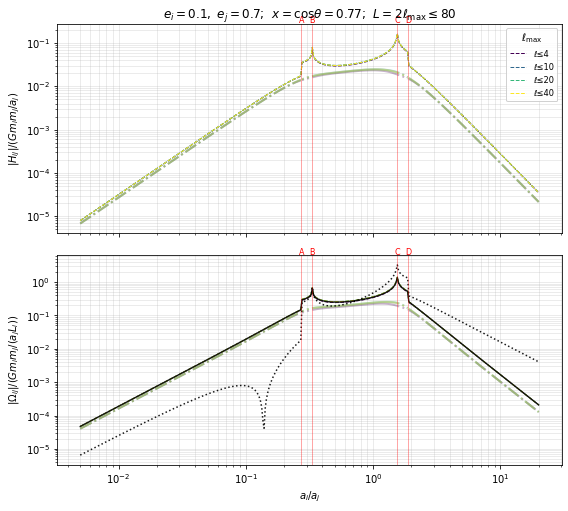

(<Figure size 576x518.4 with 2 Axes>,
 array([<AxesSubplot:title={'center':'$e_i=0.1,\\ e_j=0.7$;  $x=\\cos\\theta=0.77$;  $L=2\\ell_{\\max}\\leq 80$'}, ylabel='$|H_{ij}| / (G m_i m_j / a_j)$'>,
        <AxesSubplot:xlabel='$a_i/a_j$', ylabel='$|\\Omega_{ij}| / (G m_i m_j / (a_j L_i))$'>],
       dtype=object))

In [5]:
plot_H_Omega_vs_eta_with_asymptotics(
    e_i=0.1, e_j=0.7, cos_theta=0.77,
    L_max_list=(4, 10, 20, 40),
    I2_func=I2_from_orbits,      # your callable(ai, ei, aj, ej) -> I2
    draw_kernel=True,
    kernel_use_cot_approx=True,  # set True to use the ~ -½ cotθ form in overlap
    xlim=(None, None), ylim_H=(None, None), ylim_Om=(None, None),
    show_hybrid_omega=True
)